# Macro research
## NASDAQ vs S&P 500 - 2000 vs now


In [1]:
import pandas as pd
from yahooquery import Ticker
from fredapi import Fred
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# Initialize Yahoo Finance and FRED tickers
yahoo_tickers = {
    # Equity Indices
    "^GSPC": "S&P 500",
    "^N225": "Nikkei 225",
    "^FTSE": "FTSE 100",
    "^HSI": "Hang Seng Index",
    "^IXIC": "NASDAQ Composite",

    # Fixed Income
    "^TNX": "10-Year Treasury Yield",
    "^TYX": "30-Year Treasury Yield",
    "^FVX": "5-Year Treasury Yield",
    "^IRX": "13-Week Treasury Bill Yield",

    # Volatility
    "^VIX": "CBOE Volatility Index",

    # Crypto
    "BTC-USD": "Bitcoin_USD",
}

fred_series = {
    # Growth and Employment
    'GDP': 'Gross Domestic Product',
    'UNRATE': 'Unemployment Rate',
    'INDPRO': 'Industrial Production',
    'PAYEMS': 'Nonfarm Payrolls',
    'CIVPART': 'Labor Force Participation Rate',

    # Inflation and Prices
    'CPIAUCSL': 'Consumer Price Index',
    'PPIACO': 'Producer Price Index',
    'PCEPILFE': 'Core PCE Price Index',

    # Trade and Globalization
    'BOPGSTB': 'Trade Balance',
    'DTWEXBGS': 'US Dollar Index',

    # Financial Conditions
    'FEDFUNDS': 'Federal Funds Rate',
    'T10Y2Y': '10-Year Treasury Minus 2-Year Treasury Spread',
    'BAA10Y': 'Moody’s BAA Corporate Bond Yield Spread',
    'STLFSI': 'St. Louis Fed Financial Stress Index',
    
    # Liquidity Indicators
    'WALCL': 'Federal Reserve Balance Sheet',
    'M1SL': 'M1 Money Stock',  # NARROW
    'M2SL': 'M2 Money Stock',
    'RRPONTSYD': 'Overnight Reverse Repo Agreements',
    'TOTALSL': 'Total Assets, Liquidity Facilities',
    'DFF': 'Effective Federal Funds Rate'
}

# Initialize data containers
yahoo_data = {}
fred_data = {}

# Fetch data from Yahoo Finance
for ticker, name in yahoo_tickers.items():
    try:
        data = Ticker(ticker)
        history = data.history(period="max")
        if not history.empty:  # Ensure data exists for the ticker
            history['Ticker'] = ticker
            history['Name'] = name
            yahoo_data[ticker] = history
            print(f"Fetched data for {name} ({ticker})")
        else:
            print(f"No data for {name} ({ticker})")
            
    except Exception as e:
        print(f"Error fetching data for {name} ({ticker}): {e}")

# Fetch data from FRED API (ensure you replace the API key with your own)
fred_api_key = os.getenv('FRED_API_KEY')  # Replace with your FRED API key or set it as an environment variable
fred = Fred(api_key=fred_api_key)

for series_id, series_name in fred_series.items():
    try:
        series_data = fred.get_series(series_id)
        if series_data is not None and not series_data.empty:  # Ensure data exists for the series
            series_df = pd.DataFrame(series_data, columns=['Value'])
            series_df['Ticker'] = series_id
            series_df['Name'] = series_name
            fred_data[series_id] = series_df
            print(f"Fetched data for {series_name} ({series_id})")
        else:
            print(f"No data for {series_name} ({series_id})")
            
    except Exception as e:
        print(f"Error fetching data for {series_name} ({series_id}): {e}")

# Define time periods and their corresponding colors
time_periods = {
    "2000 Tech Boom": ("1995-01-01", "2002-12-31")
}
time_period_colors = {
    "2000 Tech Boom": "lightcoral"
}

# Combine Yahoo Finance data into a single DataFrame and save to CSV
if yahoo_data:
    df_yahoo = pd.concat(yahoo_data.values(), ignore_index=False)
    df_yahoo.reset_index(inplace=True)
    df_yahoo.to_csv('yahoo_data.csv', index=False)
else:
    print("No Yahoo Finance data to save.")

# Combine FRED data into a single DataFrame and save to CSV
if fred_data:
    df_fred = pd.concat(fred_data.values(), ignore_index=False)
    df_fred.reset_index(inplace=True)
    df_fred.rename(columns={"index":"date"}, inplace=True)
    df_fred.to_csv('fred_data.csv', index=False)
else:
    print("No FRED data to save.")

# Set 'date' as index for easier manipulation
df_yahoo.set_index('date', inplace=True)
df_fred.set_index('date', inplace=True)

# Calculate daily returns for each ticker in df_yahoo (using 'adjclose' column)
tickers_yahoo = df_yahoo['Ticker'].unique()
tickers_fred = df_fred['Ticker'].unique()

# Exclude fixed-income yield tickers for returns calculations
exclude_tickers = ['^TNX', '^TYX', "^FVX", "^IRX"]  # Exclude Treasury yields from returns calculations

# Initialize an empty DataFrame for returns
df_yahoo_returns = pd.DataFrame()

# Loop through tickers_yahoo (the list of tickers you want to process)
for ticker in tickers_yahoo:
    if ticker not in exclude_tickers:  # Only include tickers that are not in the exclude list
        # Filter the dataframe for the current ticker
        ticker_data = df_yahoo[df_yahoo['symbol'] == ticker]
        
        # Calculate percentage change for adjusted close prices and drop NaNs
        df_yahoo_returns[ticker] = ticker_data['adjclose'].pct_change().dropna()

def date_filter(df, start_date, end_date):
    """
    Filter a DataFrame by the given date range.
    Assumes the index is a datetime index.
    """
    return df[(df.index >= start_date) & (df.index <= end_date)]


def ensure_datetime_index(df):
    """
    Ensure the index is a timezone-naive datetime index.
    If the index is timezone-aware, convert to naive (UTC).
    If it's naive, just ensure it's a correct datetime format.
    
    Args:
        df (pd.DataFrame): The DataFrame whose index is to be checked and potentially converted.

    Returns:
        pd.DataFrame: The DataFrame with a timezone-naive datetime index.
    
    Raises:
        TypeError: If the index of the DataFrame is not a pd.DatetimeIndex or cannot be converted to a datetime.
    """
    if not isinstance(df.index, pd.Index):
        raise TypeError(f"Index must be a pandas Index. Found: {type(df.index)}")

    if isinstance(df.index, pd.DatetimeIndex):
        if df.index.tz is not None:
            print("Timezone-aware datetime detected. Converting to naive datetime (UTC).")
            df.index = df.index.tz_convert('UTC').tz_localize(None)
        else:
            print("Timezone-naive datetime detected.")
    else:
        print("Index is not a datetime type. Attempting to convert to datetime.")
        try:
            df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
        except ValueError as e:
            print(f"Error converting index to datetime: {e}")
            print("Attempting to convert with 'coerce' option...")
            df.index = pd.to_datetime(df.index, errors='coerce', utc=True).tz_localize(None)

    if df.index.hasnans:
        print("Warning: Index contains NaT values after conversion.")
        
    return df

# Apply the data cleaning functions to your DataFrames
df_fred = ensure_datetime_index(df_fred)
df_yahoo = ensure_datetime_index(df_yahoo)
df_yahoo_returns = ensure_datetime_index(df_yahoo_returns)

df_fred.dropna(inplace=True)

Fetched data for S&P 500 (^GSPC)
Fetched data for Nikkei 225 (^N225)
Fetched data for FTSE 100 (^FTSE)
Fetched data for Hang Seng Index (^HSI)
Fetched data for NASDAQ Composite (^IXIC)
Fetched data for 10-Year Treasury Yield (^TNX)
Fetched data for 30-Year Treasury Yield (^TYX)
Fetched data for 5-Year Treasury Yield (^FVX)
Fetched data for 13-Week Treasury Bill Yield (^IRX)
Fetched data for CBOE Volatility Index (^VIX)
Fetched data for Bitcoin_USD (BTC-USD)
Fetched data for Gross Domestic Product (GDP)
Fetched data for Unemployment Rate (UNRATE)
Fetched data for Industrial Production (INDPRO)
Fetched data for Nonfarm Payrolls (PAYEMS)
Fetched data for Labor Force Participation Rate (CIVPART)
Fetched data for Consumer Price Index (CPIAUCSL)
Fetched data for Producer Price Index (PPIACO)
Fetched data for Core PCE Price Index (PCEPILFE)
Fetched data for Trade Balance (BOPGSTB)
Fetched data for US Dollar Index (DTWEXBGS)
Fetched data for Federal Funds Rate (FEDFUNDS)
Fetched data for 10-Ye

NASDAQ Change after event (30 days): 38.5705950632612%
S&P 500 Change after event (30 days): -23.339641877322304%


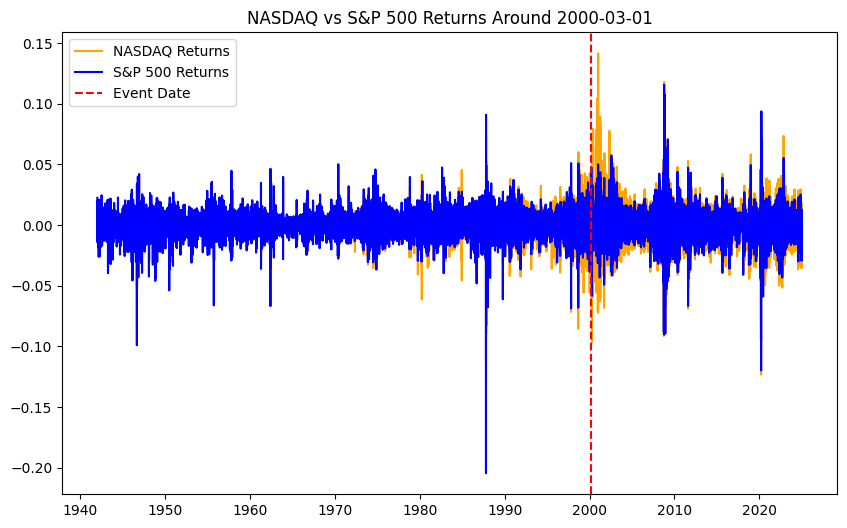

Regression Coefficients: [ 0.04218062 -0.18800414]
Intercept: 7.90437513289732e-18


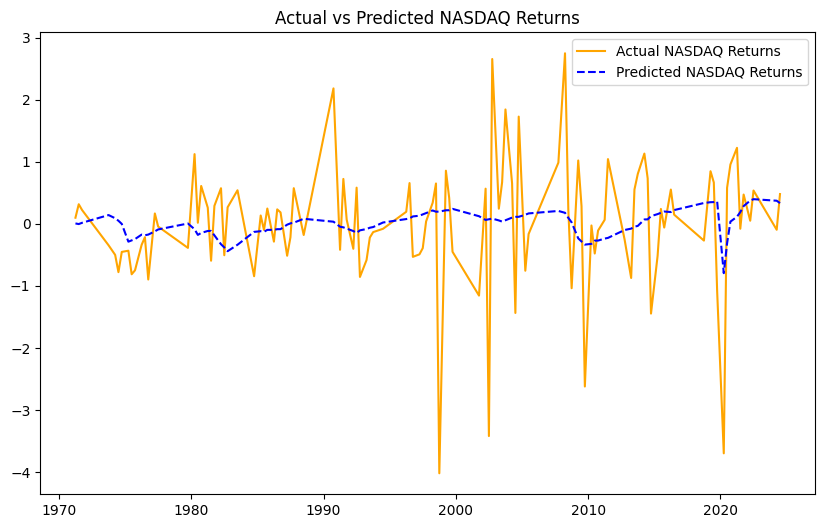

In [2]:
# Define event-driven analysis function
def event_driven_change(event_date, df, column_name, days=30):
    """
    Calculate the percentage change in a specified column after a given event date.
    """
    # Ensure the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column {column_name} does not exist in the DataFrame.")
    
    # Check if the event_date is in the dataframe
    if event_date not in df.index:
        # Find the closest available date (nearest)
        timedeltas = df.index - event_date
        closest_date = df.index[(np.abs(timedeltas)).argmin()]
        print(f"Event date {event_date} not found. Using closest available date: {closest_date}")
        event_date = closest_date
    
    # Get the value on the event date for the selected column
    value_on_event_date = df.loc[event_date, column_name]
    
    # Calculate the end date (30 days later)
    end_date = event_date + pd.Timedelta(days=days)
    
    # Check if end_date exists in the DataFrame, if not, use the closest available date
    if end_date not in df.index:
        # Find the closest available end_date (bfill)
        timedeltas = df.index - end_date
        end_date = df.index[(np.abs(timedeltas)).argmin()]
        print(f"End date {end_date} not found. Using closest available date.")
    
    # Get the value 30 days after the event date
    value_30_days_after = df.loc[end_date, column_name]
    
    # Calculate the percentage change
    if value_on_event_date == 0:
        return np.nan  # Avoid division by zero
    percentage_change = (value_30_days_after - value_on_event_date) / value_on_event_date * 100
    
    return percentage_change

# Example: Test event-driven changes for ^IXIC and S&P 500 during an event (e.g., geopolitical risk event)
event_date = pd.Timestamp('2000-03-01')
nasdaq_change = event_driven_change(event_date, df_yahoo_returns, '^IXIC')
sp500_change = event_driven_change(event_date, df_yahoo_returns, '^GSPC')

print(f"NASDAQ Change after event (30 days): {nasdaq_change}%")
print(f"S&P 500 Change after event (30 days): {sp500_change}%")

# Visualize the event-driven analysis (NASDAQ vs S&P 500)
plt.figure(figsize=(10,6))
plt.plot(df_yahoo_returns.index, df_yahoo_returns['^IXIC'], label='NASDAQ Returns', color='orange')
plt.plot(df_yahoo_returns.index, df_yahoo_returns['^GSPC'], label='S&P 500 Returns', color='blue')
plt.axvline(x=event_date, color='red', linestyle='--', label='Event Date')
plt.title(f"NASDAQ vs S&P 500 Returns Around {event_date.strftime('%Y-%m-%d')}")
plt.legend()
plt.show()

# Extract relevant FRED variables (GDP and Unemployment Rate)
gdp_data = df_fred[df_fred['Ticker'] == 'GDP'][['Value']].rename(columns={'Value': 'GDP'})
unemployment_data = df_fred[df_fred['Ticker'] == 'UNRATE'][['Value']].rename(columns={'Value': 'Unemployment Rate'})

# Merge the dataframes: Yahoo returns and FRED data
df_combined = pd.concat([df_yahoo_returns['^IXIC'], gdp_data, unemployment_data], axis=1).dropna()

# Standardize the data (important for regression)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_combined), columns=df_combined.columns, index=df_combined.index)

# Linear Regression Model
X = df_scaled[['GDP', 'Unemployment Rate']]  # Independent variables (predictors)
y = df_scaled['^IXIC']  # Dependent variable (target)

# Create and fit the regression model
model = LinearRegression()
model.fit(X, y)

# Output coefficients and intercept
print(f"Regression Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")

# Predict NASDAQ returns using the model
df_scaled['Predicted ^IXIC'] = model.predict(X)

# Plot the actual vs predicted NASDAQ returns
plt.figure(figsize=(10, 6))
plt.plot(df_scaled.index, df_scaled['^IXIC'], label='Actual NASDAQ Returns', color='orange')
plt.plot(df_scaled.index, df_scaled['Predicted ^IXIC'], label='Predicted NASDAQ Returns', color='blue', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted NASDAQ Returns')
plt.show()


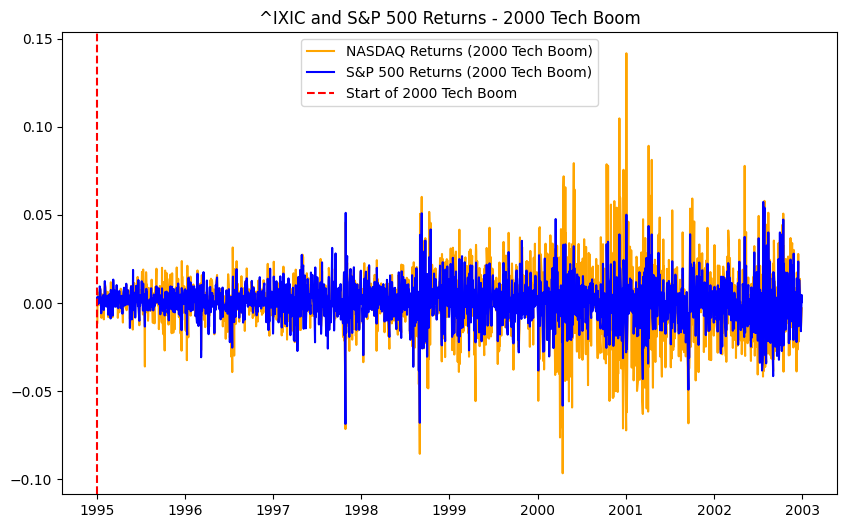

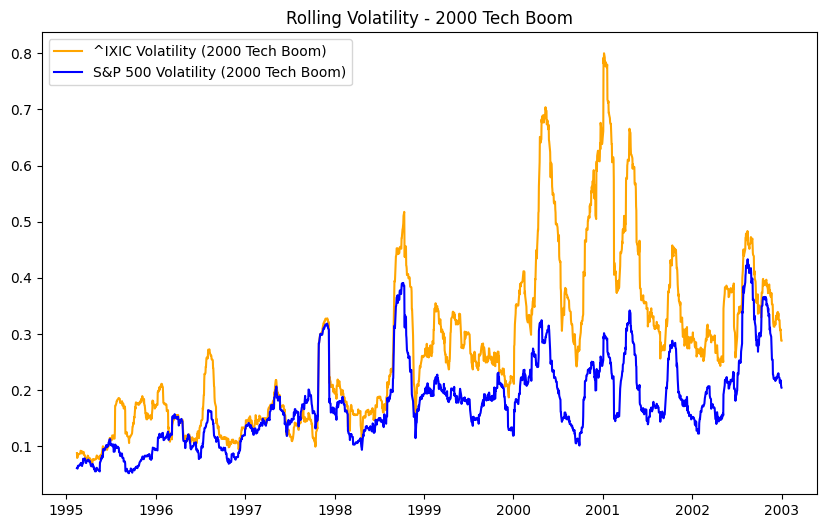

Sharpe Ratio (2000 Tech Boom): 0.2508114043612954
Max Drawdown (2000 Tech Boom): -0.779323862859341
Correlation between NASDAQ and S&P 500 (2000 Tech Boom): 0.8315468860348029


In [3]:
def filter_data_by_period(df, period):
    start_date, end_date = time_periods[period]
    return date_filter(df, start_date, end_date)

# Volatility calculation function
def calculate_rolling_volatility(df, window=30):
    return df.rolling(window=window).std() * np.sqrt(252)  # Annualized volatility

# Sharpe ratio function
def calculate_sharpe_ratio(returns, risk_free_rate=0.042): # assume 4.2% risk free
    excess_returns = returns - risk_free_rate / 252  # Assume daily risk-free rate
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

# Drawdown function
def calculate_drawdowns(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()  # Return max drawdown

# Correlation function
def calculate_correlation(df, col1, col2):
    return df[col1].corr(df[col2])

# # Filter data for different periods
# df_yahoo_returns_post_2022 = filter_data_by_period(df_yahoo_returns, "Post-2022 AI Tech Boom")
# df_yahoo_returns_cold_war = filter_data_by_period(df_yahoo_returns, "Cold War")
df_yahoo_returns_2000_boom = filter_data_by_period(df_yahoo_returns, "2000 Tech Boom")

plt.figure(figsize=(10, 6))
plt.plot(df_yahoo_returns_2000_boom.index, df_yahoo_returns_2000_boom['^IXIC'], label='NASDAQ Returns (2000 Tech Boom)', color='orange')
plt.plot(df_yahoo_returns_2000_boom.index, df_yahoo_returns_2000_boom['^GSPC'], label='S&P 500 Returns (2000 Tech Boom)', color='blue')
plt.axvline(x=pd.Timestamp('1995-01-01'), color='red', linestyle='--', label='Start of 2000 Tech Boom')
plt.title('^IXIC and S&P 500 Returns - 2000 Tech Boom')
plt.legend()
plt.show()


volatility_nasdaq_2000_boom = calculate_rolling_volatility(df_yahoo_returns_2000_boom['^IXIC'])
volatility_sp500_2000_boom = calculate_rolling_volatility(df_yahoo_returns_2000_boom['^GSPC'])


plt.figure(figsize=(10, 6))
plt.plot(volatility_nasdaq_2000_boom.index, volatility_nasdaq_2000_boom, label='^IXIC Volatility (2000 Tech Boom)', color='orange')
plt.plot(volatility_sp500_2000_boom.index, volatility_sp500_2000_boom, label='S&P 500 Volatility (2000 Tech Boom)', color='blue')
plt.title('Rolling Volatility - 2000 Tech Boom')
plt.legend()
plt.show()


sharpe_2000_boom = calculate_sharpe_ratio(df_yahoo_returns_2000_boom['^IXIC'])

drawdown_2000_boom = calculate_drawdowns(df_yahoo_returns_2000_boom['^IXIC'])

# Output Sharpe ratio and max drawdown results

print(f"Sharpe Ratio (2000 Tech Boom): {sharpe_2000_boom}")

print(f"Max Drawdown (2000 Tech Boom): {drawdown_2000_boom}")

# Correlation analysis

correlation_2000_boom = calculate_correlation(df_yahoo_returns_2000_boom, '^IXIC', '^GSPC')
print(f"Correlation between NASDAQ and S&P 500 (2000 Tech Boom): {correlation_2000_boom}")


In [4]:
import yfinance as yf

# Load SPY and QQQ ticker objects
spy = yf.Ticker("SPY")
qqq = yf.Ticker("QQQ")

# Get the expiration dates for both SPY and QQQ
spy_expirations = spy.options
qqq_expirations = qqq.options

# Choose a date for options chain analysis (let's pick the first expiration date for simplicity)
spy_chain = spy.option_chain(spy_expirations[0])
qqq_chain = qqq.option_chain(qqq_expirations[0])

# Now, we can access the calls and puts for both SPY and QQQ
spy_calls = spy_chain.calls
spy_puts = spy_chain.puts
qqq_calls = qqq_chain.calls
qqq_puts = qqq_chain.puts

# Print some basic data for SPY calls and puts
print("SPY Calls:")
print(spy_calls[['strike', 'lastPrice', 'impliedVolatility', 'openInterest']].head())

print("\nSPY Puts:")
print(spy_puts[['strike', 'lastPrice', 'impliedVolatility', 'openInterest']].head())

# Print some basic data for QQQ calls and puts
print("\nQQQ Calls:")
print(qqq_calls[['strike', 'lastPrice', 'impliedVolatility', 'openInterest']].head())

print("\nQQQ Puts:")
print(qqq_puts[['strike', 'lastPrice', 'impliedVolatility', 'openInterest']].head())

# Optionally, you can analyze implied volatility or open interest to gauge expectations
# Example: Checking average implied volatility for SPY Calls and Puts
avg_spy_call_iv = spy_calls['impliedVolatility'].mean()
avg_spy_put_iv = spy_puts['impliedVolatility'].mean()

# Example: Checking total open interest for SPY Calls and Puts
total_spy_call_open_interest = spy_calls['openInterest'].sum()
total_spy_put_open_interest = spy_puts['openInterest'].sum()

# Print IV and open interest insights
print(f"\nAverage SPY Call IV: {avg_spy_call_iv:.4f}")
print(f"Average SPY Put IV: {avg_spy_put_iv:.4f}")
print(f"Total SPY Call Open Interest: {total_spy_call_open_interest}")
print(f"Total SPY Put Open Interest: {total_spy_put_open_interest}")

# Generate insights
def generate_insights():
    # SPY Insights
    spy_insight = ""
    if avg_spy_call_iv < avg_spy_put_iv:
        spy_insight += "For SPY, implied volatility on puts is higher than calls, suggesting market participants are more cautious about potential downside risk. "
    else:
        spy_insight += "For SPY, implied volatility on calls is higher than puts, suggesting traders expect more uncertainty and potential for price increases. "

    if total_spy_call_open_interest > total_spy_put_open_interest:
        spy_insight += "There is higher open interest in calls than puts, indicating a bullish sentiment in the market. "
    else:
        spy_insight += "There is more open interest in puts than calls, which could suggest some bearish positioning. "

    # QQQ Insights
    qqq_insight = ""
    if avg_spy_call_iv < 0.75 and avg_spy_put_iv < 0.75:
        qqq_insight += "For QQQ, both call and put options show relatively low implied volatility, indicating that the market doesn't expect significant price moves. "
    else:
        qqq_insight += "For QQQ, there is some volatility pricing in the options, suggesting that market participants are expecting price movements, but nothing extreme. "
    
    if total_spy_call_open_interest < total_spy_put_open_interest:
        qqq_insight += "However, the open interest in puts for QQQ is higher than in calls, which suggests there could be some concern about downside risks in the market. "
    else:
        qqq_insight += "The open interest in calls is also notable, indicating that some traders are expecting the price to rise."

    return spy_insight + qqq_insight

# Print insights
insights = generate_insights()
print("\nMarket Insights:")
print(insights)


SPY Calls:
   strike  lastPrice  impliedVolatility  openInterest
0   370.0     216.76           3.859375           398
1   380.0     207.79           3.662110             1
2   490.0     102.10           1.732423             0
3   495.0      97.05           1.652345             0
4   500.0      90.71           1.572268             1

SPY Puts:
   strike  lastPrice  impliedVolatility  openInterest
0   370.0       0.01           2.625003           0.0
1   380.0       0.01           2.500004           1.0
2   385.0       0.01           2.375004           0.0
3   390.0       0.01           2.312504          10.0
4   395.0       0.02           2.250004           1.0

QQQ Calls:
   strike  lastPrice  impliedVolatility  openInterest
0   450.0      69.00           1.271488             8
1   457.0      59.59           1.150395             1
2   460.0      59.12           1.099614            25
3   463.0      54.66           1.046880             1
4   469.0      46.99           0.945313         

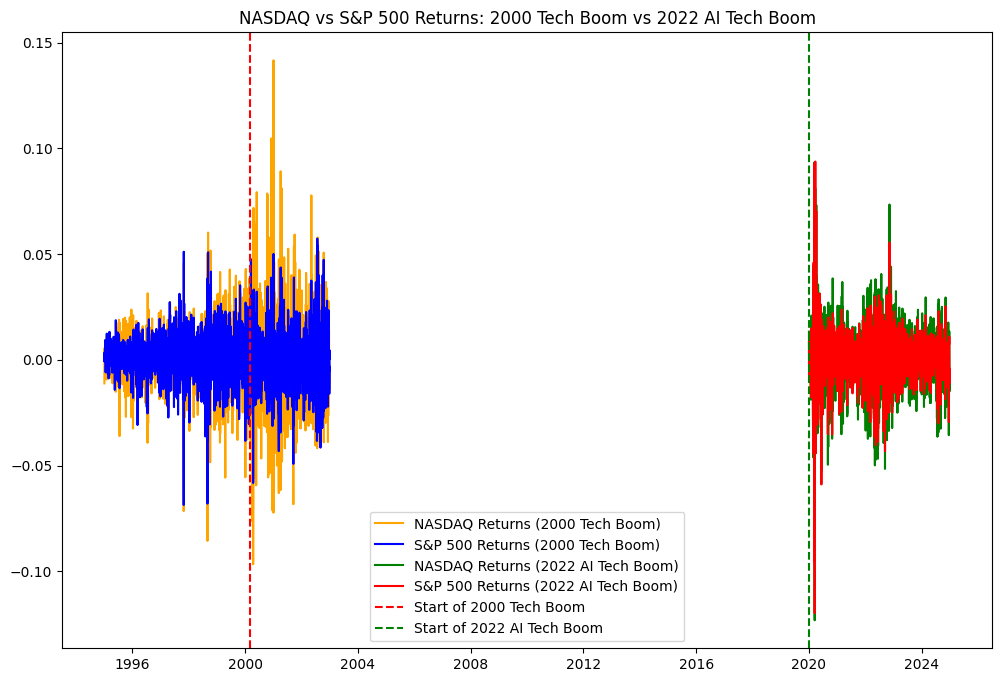

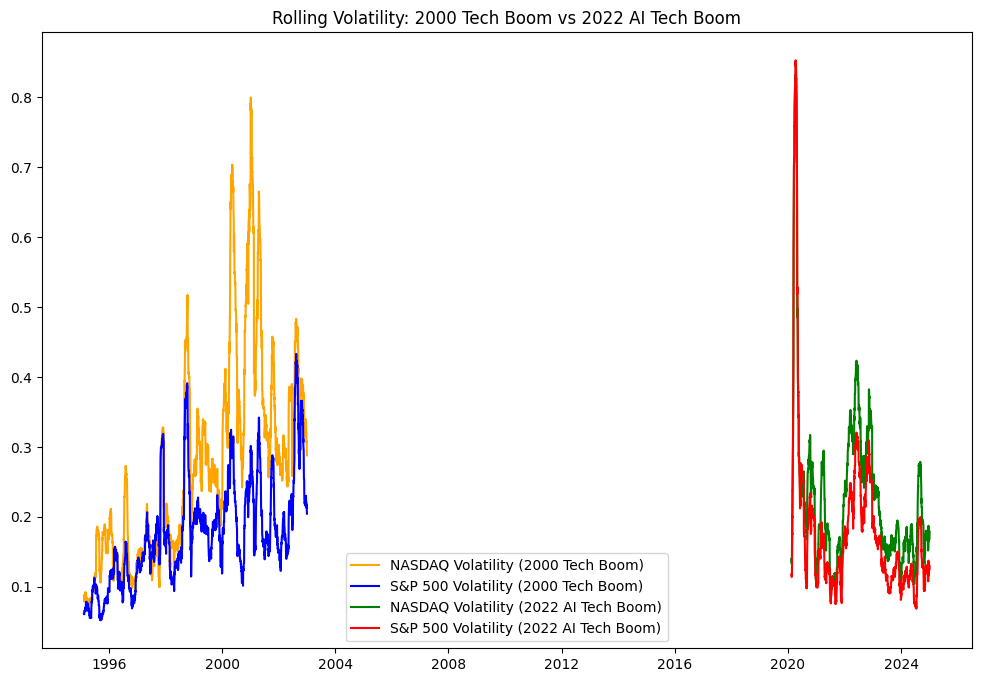

Sharpe Ratio (2000 Tech Boom): 0.2508114043612954
Sharpe Ratio (2022 AI Tech Boom): 0.5660401362224003
Max Drawdown (2000 Tech Boom): -0.779323862859341
Max Drawdown (2022 AI Tech Boom): -0.3639527990912015
Correlation between NASDAQ and S&P 500 (2000 Tech Boom): 0.8315468860348029
Correlation between NASDAQ and S&P 500 (2022 AI Tech Boom): 0.9458352277219637
Event date 2022-01-01 00:00:00 not found. Using closest available date: 2021-12-31 00:00:00
End date 2022-01-31 00:00:00 not found. Using closest available date.
Event date 2022-01-01 00:00:00 not found. Using closest available date: 2021-12-31 00:00:00
End date 2022-01-31 00:00:00 not found. Using closest available date.
NASDAQ Change after 2000 Event (30 days): 38.5705950632612%
S&P 500 Change after 2000 Event (30 days): -23.339641877322304%
NASDAQ Change after 2022 Event (30 days): -655.4228942458418%
S&P 500 Change after 2022 Event (30 days): -819.1415803069102%


In [5]:
# Define time periods for 2022 AI Tech Boom
time_periods["2022 AI Tech Boom"] = ("2020-01-01", "2024-12-31")
time_period_colors["2022 AI Tech Boom"] = "lightgreen"

# Function to compare Tech Boom events (2000 vs 2022)
def compare_tech_booms():
    # Filter data for 2000 Tech Boom and 2022 AI Tech Boom periods
    df_yahoo_returns_2022_boom = filter_data_by_period(df_yahoo_returns, "2022 AI Tech Boom")
    df_yahoo_returns_2000_boom = filter_data_by_period(df_yahoo_returns, "2000 Tech Boom")

    # Plot NASDAQ and S&P 500 returns for both periods
    plt.figure(figsize=(12, 8))
    plt.plot(df_yahoo_returns_2000_boom.index, df_yahoo_returns_2000_boom['^IXIC'], label='NASDAQ Returns (2000 Tech Boom)', color='orange')
    plt.plot(df_yahoo_returns_2000_boom.index, df_yahoo_returns_2000_boom['^GSPC'], label='S&P 500 Returns (2000 Tech Boom)', color='blue')
    plt.plot(df_yahoo_returns_2022_boom.index, df_yahoo_returns_2022_boom['^IXIC'], label='NASDAQ Returns (2022 AI Tech Boom)', color='green')
    plt.plot(df_yahoo_returns_2022_boom.index, df_yahoo_returns_2022_boom['^GSPC'], label='S&P 500 Returns (2022 AI Tech Boom)', color='red')
    plt.axvline(x=pd.Timestamp('2000-03-01'), color='red', linestyle='--', label='Start of 2000 Tech Boom')
    plt.axvline(x=pd.Timestamp('2020-01-01'), color='green', linestyle='--', label='Start of 2022 AI Tech Boom')
    plt.title('NASDAQ vs S&P 500 Returns: 2000 Tech Boom vs 2022 AI Tech Boom')
    plt.legend()
    plt.show()

    # Compare Volatility (Rolling Std Dev)
    volatility_nasdaq_2022_boom = calculate_rolling_volatility(df_yahoo_returns_2022_boom['^IXIC'])
    volatility_sp500_2022_boom = calculate_rolling_volatility(df_yahoo_returns_2022_boom['^GSPC'])

    plt.figure(figsize=(12, 8))
    plt.plot(volatility_nasdaq_2000_boom.index, volatility_nasdaq_2000_boom, label='NASDAQ Volatility (2000 Tech Boom)', color='orange')
    plt.plot(volatility_sp500_2000_boom.index, volatility_sp500_2000_boom, label='S&P 500 Volatility (2000 Tech Boom)', color='blue')
    plt.plot(volatility_nasdaq_2022_boom.index, volatility_nasdaq_2022_boom, label='NASDAQ Volatility (2022 AI Tech Boom)', color='green')
    plt.plot(volatility_sp500_2022_boom.index, volatility_sp500_2022_boom, label='S&P 500 Volatility (2022 AI Tech Boom)', color='red')
    plt.title('Rolling Volatility: 2000 Tech Boom vs 2022 AI Tech Boom')
    plt.legend()
    plt.show()

    # Sharpe Ratio and Max Drawdown comparison for both periods
    sharpe_2000_boom = calculate_sharpe_ratio(df_yahoo_returns_2000_boom['^IXIC'])
    sharpe_2022_boom = calculate_sharpe_ratio(df_yahoo_returns_2022_boom['^IXIC'])

    drawdown_2000_boom = calculate_drawdowns(df_yahoo_returns_2000_boom['^IXIC'])
    drawdown_2022_boom = calculate_drawdowns(df_yahoo_returns_2022_boom['^IXIC'])

    print(f"Sharpe Ratio (2000 Tech Boom): {sharpe_2000_boom}")
    print(f"Sharpe Ratio (2022 AI Tech Boom): {sharpe_2022_boom}")
    print(f"Max Drawdown (2000 Tech Boom): {drawdown_2000_boom}")
    print(f"Max Drawdown (2022 AI Tech Boom): {drawdown_2022_boom}")

    # Correlation comparison between NASDAQ and S&P 500 for both periods
    correlation_2000_boom = calculate_correlation(df_yahoo_returns_2000_boom, '^IXIC', '^GSPC')
    correlation_2022_boom = calculate_correlation(df_yahoo_returns_2022_boom, '^IXIC', '^GSPC')

    print(f"Correlation between NASDAQ and S&P 500 (2000 Tech Boom): {correlation_2000_boom}")
    print(f"Correlation between NASDAQ and S&P 500 (2022 AI Tech Boom): {correlation_2022_boom}")

# Run the comparison function
compare_tech_booms()

# %% 
# Extend event-driven analysis to compare both Tech Booms (2000 vs 2022)
def compare_event_driven_changes():
    # Define event dates for 2000 and 2022 Tech Booms
    event_date_2000 = pd.Timestamp('2000-03-01')
    event_date_2022 = pd.Timestamp('2022-01-01')

    # Calculate percentage change for NASDAQ and S&P 500 for both events
    nasdaq_change_2000 = event_driven_change(event_date_2000, df_yahoo_returns, '^IXIC')
    sp500_change_2000 = event_driven_change(event_date_2000, df_yahoo_returns, '^GSPC')

    nasdaq_change_2022 = event_driven_change(event_date_2022, df_yahoo_returns, '^IXIC')
    sp500_change_2022 = event_driven_change(event_date_2022, df_yahoo_returns, '^GSPC')

    print(f"NASDAQ Change after 2000 Event (30 days): {nasdaq_change_2000}%")
    print(f"S&P 500 Change after 2000 Event (30 days): {sp500_change_2000}%")
    print(f"NASDAQ Change after 2022 Event (30 days): {nasdaq_change_2022}%")
    print(f"S&P 500 Change after 2022 Event (30 days): {sp500_change_2022}%")

# Run event-driven analysis for both tech booms
compare_event_driven_changes()
